In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

In [2]:
data = pd.read_excel("Source Data 4 The source data for Figure 4 in manuscript.xlsx")

In [12]:
def get_x_y(data, target_variable_name, use_target_features):
    target = data[target_variable_name]
    if use_target_features:
        features = data[data.columns[:21]].drop(target_variable_name, axis=1)
    else:
        features = data[data.columns[:18]]
    return features, target

def plot_feature_importance(data, target_variable_name, use_target_features):
    features, target = get_x_y(data, target_variable_name, use_target_features)
    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(features, target)
    importances = clf.feature_importances_
    features_names = features.columns
    indices = np.argsort(importances)[::-1]
    features_names = [features_names[i] for i in indices]
    importances = [importances[i] for i in indices]
    
    out = "" if use_target_features else "out"
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature importances for predicting {target_variable_name} with{out} other target features")
    plt.bar(range(features.shape[1]), importances, color="r", align="center")
    plt.xticks(range(features.shape[1]), features_names, rotation='vertical')
    plt.xlim([-1, features.shape[1]])
    plt.show()

def plot_roc_curves(data, target_variable_name):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    skf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    
    X = features.values
    y = target.values

    clf = RandomForestClassifier(n_estimators=20, random_state=42)
    clf.fit(X, y)

    lb = LabelBinarizer()
    lb.fit(y)
    
    l_one_hot = lb.transform(y)
    
    y_score = clf.predict_proba(X)
    
    for i in range(10):
        fpr, tpr, _ = roc_curve(l_one_hot[:, i], y_score[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"R{i+1} AUC={auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate", size=13)
    plt.ylabel("True Positive Rate", size=13)
    plt.legend()
    plt.show()

def get_cv_accuracies(features, target, train_on_test_data, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    X = features.values
    y = target.values
    accuracies = []
    if train_on_test_data:
        clf = RandomForestClassifier(n_estimators=20, random_state=42)
        clf.fit(X, y)
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if not train_on_test_data:
            clf = RandomForestClassifier(n_estimators=20, random_state=42)
            clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
    return accuracies

def get_avg_auc_score(data, target_variable_name, train_on_test_data, n_folds):
    features, target = get_x_y(data, target_variable_name, use_target_features=False)
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    X = features.values
    y = target.values
    lb = LabelBinarizer()
    lb.fit(y)
    
    auc_scores = []
    if train_on_test_data:
        clf = RandomForestClassifier(n_estimators=20, random_state=42)
        clf.fit(X, y)
        y_score = clf.predict_proba(X)
        y_test_bin = lb.transform(y)
        
        per_class_auc = []
        for i in range(10):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            per_class_auc.append(auc(fpr, tpr))
        return np.mean(per_class_auc)
    else:
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = RandomForestClassifier(n_estimators=20, random_state=42)
            clf.fit(X_train, y_train)
            y_score = clf.predict_proba(X_test)
            y_test_bin = lb.transform(y_test)

            per_class_auc = []
            for i in range(10):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                per_class_auc.append(auc(fpr, tpr))
            auc_scores.append(np.mean(per_class_auc))

        return np.mean(auc_scores)

import matplotlib.patches as patches
def plot_accuracies(data, target_names, train_on_test_data, n_folds):
    fig, ax = plt.subplots()
    for target_name in target_names:
        features, target = get_x_y(data, target_name, use_target_features=False)
        accuracies = get_cv_accuracies(features, target, train_on_test_data, n_folds)
        max_val = np.max(accuracies)
        max_ind = np.argmax(accuracies)
        ax.plot(np.arange(1, n_folds + 1), accuracies, label=target_name)
        if target_name == 'rank-kmeans':
            W = 0.2
            ellipse = patches.Ellipse((max_ind + 1, max_val), width=W, height=0.12 * W, edgecolor='r', facecolor='none')
            ax.add_patch(ellipse)
            ax.text(max_ind + 1.1, max_val, f'{100 * max_val:.2f}%', fontsize=10)
        ax.set_ylim((0.1, 0.9))
        ax.legend()
        print(f'Average Accuracy for {target_name}: {100 * np.mean(accuracies):.2f}%')
    ax.legend()

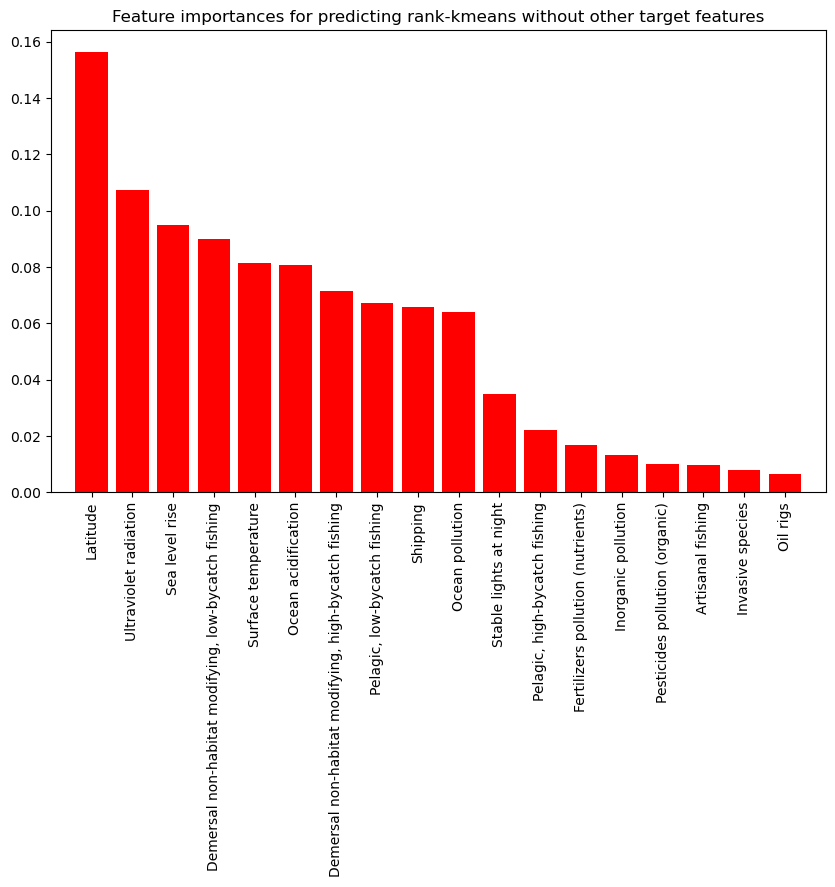

In [4]:
plot_feature_importance(data, 'rank-kmeans', use_target_features=False)

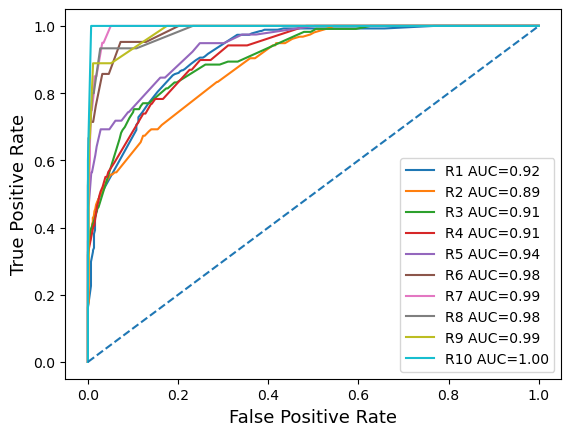

In [5]:
plot_roc_curves(data, 'rank-kmeans')

Average Accuracy for rank-kmeans: 69.24%
Average Accuracy for rank-equalfrequency: 57.72%


Text(0.5, 0, 'Round')

<Figure size 600x600 with 0 Axes>

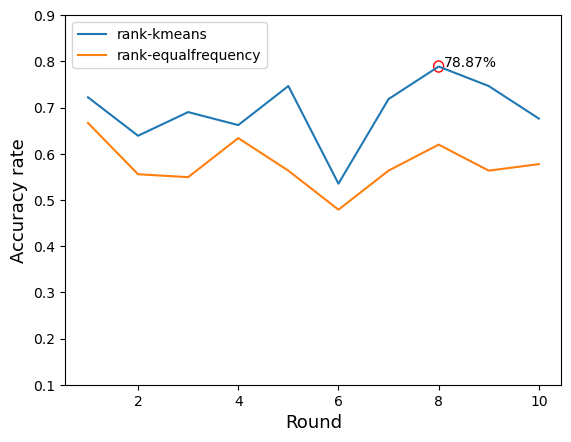

In [13]:
plt.figure(figsize=(6, 6))
plot_accuracies(data, ['rank-kmeans', 'rank-equalfrequency'], train_on_test_data=True, n_folds=10)
plt.ylabel("Accuracy rate", size=13)
plt.xlabel("Round", size=13)

Average Accuracy for rank-kmeans: 36.39%
Average Accuracy for rank-equalfrequency: 18.68%


Text(0.5, 0, 'Round')

<Figure size 600x600 with 0 Axes>

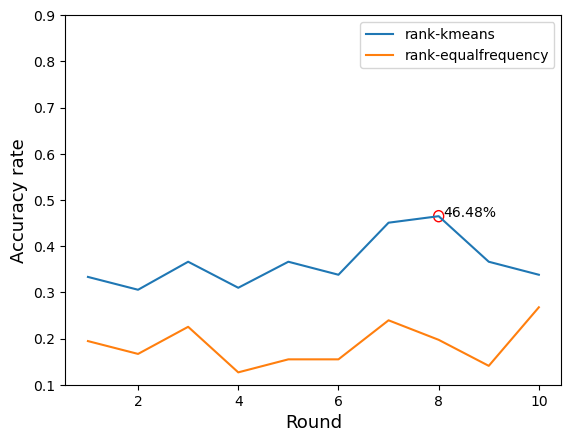

In [14]:
plt.figure(figsize=(6, 6))
plot_accuracies(data, ['rank-kmeans', 'rank-equalfrequency'], train_on_test_data=False, n_folds=10)
plt.ylabel("Accuracy rate", size=13)
plt.xlabel("Round", size=13)

In [15]:
get_avg_auc_score(data, 'rank-kmeans', train_on_test_data=True, n_folds=5)

0.9509423762741369

In [16]:
get_avg_auc_score(data, 'rank-kmeans', train_on_test_data=False, n_folds=5)

0.6418578491549913